# DQN

Метод обучения DQN — это нейросетевая адаптация алгоритма Q-learning. Также для него разработан набор дополнений, которые становятся актуальными при переходе к обучению глубоких нейронных сетей и решению более сложных задач (то есть задач с бОльшим пространством состояний).

Реализуем алгоритм DQN для решения среды [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/), цель которой балансировать палочкой в вертикальном положении, управляя только тележкой, к которой она прикреплена. Будем использовать библиотеку PyTorch для обучения нейронной сети, аппроксимирующей Q-функцию (но вы можете воспользоваться и любой другой библиотекой для обучения глубоких сетей, таких как TensorFlow или Jax). 

![cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)

![cartpole](https://www.researchgate.net/publication/362568623/figure/fig5/AS:1187029731807278@1660021350587/Screen-capture-of-the-OpenAI-Gym-CartPole-problem-with-annotations-showing-the-cart.png)

In [1]:
# Cтавим нужные зависимости, если это колаб
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
from IPython.display import HTML
from base64 import b64encode
import glob
import os
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
%matplotlib inline

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

**Note:** While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

- The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
- The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates
   if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

### Rewards

Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,
including the termination step, is allotted. The threshold for rewards is 500 for v1 and 200 for v0.

### Starting State

All observations are assigned a uniformly random value in `(-0.05, 0.05)`

### Episode End

The episode ends if any one of the following occurs:

1. Termination: Pole Angle is greater than ±12°
2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
3. Truncation: Episode length is greater than 500 (200 for v0)

In [3]:
env = gym.make("CartPole-v1", max_episode_steps=1000)
env.reset()

# Выведем информацию о пространствах состояний и действий
print(f'{env.observation_space=}')
print(f'{env.action_space=}')

n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(f'Action_space: {n_actions} | State_space: {state_dim}')

env.observation_space=Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
env.action_space=Discrete(2)
Action_space: 2 | State_space: (4,)


Т.к. описание состояния в задаче с маятником представляет собой не "сырые" признаки, а уже предобработанные (координаты, углы), нам не нужна для начала сложная архитектура, начнем с такой:
<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2020/RL/figures/DQN.svg">

Будем использовать только полносвязные слои (``torch.nn.Linear``) и простые активационные функции (``torch.nn.ReLU``). Сигмоиды и другие похожие функции активации могут плохо работать с ненормализованными входными данными.

Будем приближать Q-функцию агента, минимизируя среднеквадратичную TD-ошибку:
$$
\delta = Q_{\theta}(s, a) - [r(s, a) + \gamma \cdot max_{a'} Q_{-}(s', a')]
$$
$$
L = \frac{1}{N} \sum_i \delta_i^2,
$$
где
* $s, a, r, s'$ состояние, действие, вознаграждение и следующее состояние 
* $\gamma$ дисконтирующий множитель.

Основная тонкость состоит в использовании $Q_{-}(s',a')$. Это та же самая функция, что и $Q_{\theta}$, которая является выходом нейронной сети, но при обучении сети, мы не пропускаем через эти слои градиенты. В научных статьях можно обнаружить следующее обозначение для остановки градиента: $SG(\cdot)$. В PyTorch есть метод `.detach()` класса `Tensor`, который возвращает тензор с выключенными градиентами, а также контекстный менеджер `with torch.no_grad()`, который задает контекст с вычислениями, для которых не вычисляется градиент.

In [4]:
import torch
import torch.nn as nn

def create_network(input_dim, hidden_dims, output_dim):
    # network = nn.Sequential(
    #    torch.nn.Linear(input_dim, ...),
    #    torch.nn.ReLU() or Tanh(),
    #    ...
    # )
    """<codehere>"""
    from_dim = input_dim
    layers = []
    for to_dim in hidden_dims:
        layers.extend([
            nn.Linear(from_dim, to_dim),
            nn.Tanh()
        ])
        from_dim = to_dim

    layers.append(nn.Linear(from_dim, output_dim))
    network = nn.Sequential(*layers)
    """</codehere>"""
    return network

Добавим $\epsilon$-жадный выбор действий:

In [5]:
def select_action_eps_greedy(Q, state, epsilon):
    """Выбирает действие epsilon-жадно."""
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32)

    Q_s = Q(state).detach().numpy()
    
    """<codehere>"""
    if np.random.random() < epsilon:
        n_actions = Q_s.shape[-1]
        action = np.random.choice(n_actions)
    else:
        action = np.argmax(Q_s)
    """</codehere>"""
    
    action = int(action)
    return action

Q = create_network(
    input_dim=np.prod(state_dim), 
    hidden_dims=[64, 64], 
    output_dim=n_actions
)

print("Полученная архитектура сети:")
print(Q)

print("\nЧисло параметров сети:")
total_params = sum(p.numel() for p in Q.parameters())
print(total_params)

# for name, param in Q.named_parameters():
#     print(f"{name}: {param.shape}")

print("\nПример выбора действия:")
select_action_eps_greedy(
    Q=Q, 
    state=env.reset()[0].flatten(), 
    epsilon=0.1
)

Полученная архитектура сети:
Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

Число параметров сети:
4610

Пример выбора действия:


0

In [6]:
def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x

    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)

    return x

def compute_td_loss(
    Q, # Q-сеть
    states, # Текущие состояния
    actions, # Выбранные действия
    rewards, # Вознаграждения
    next_states, # Следующие состояния
    terminateds, # Флаги завершения эпизодов
    gamma=0.99, # Дисконтирующий множитель
    check_shapes=False, # Флаг для проверки формы тензоров
    regularizer=.1, # Параметр регуляризации
    out_non_reduced_losses=False # Флаг для вывода несглаженных TD ошибок
):
    """ Считает TD ошибку."""

    # Преобразуем входные данные в тензоры
    s = to_tensor(states)               # shape: [batch_size, state_size]
    a = to_tensor(actions, int).long()  # shape: [batch_size]
    r = to_tensor(rewards)              # shape: [batch_size]
    s_next = to_tensor(next_states)     # shape: [batch_size, state_size]
    term = to_tensor(terminateds, bool) # shape: [batch_size]

    # Q_s_a = ...
    """<codehere>"""
    Q_s_a = torch.gather(
            Q(s), dim=1, index=torch.unsqueeze(a, 1)
        ).squeeze(-1)
    """</codehere>"""

    # получаем Q[s_next, .] — значения полезности всех действий в следующем состоянии
    # Q_sn = ...,
    # а затем вычисляем V^*[s_next] — оптимальные значения полезности следующем состоянии
    # V_sn = ...

    """<codehere>"""
    with torch.no_grad(): # контекстный менеджер PyTorch, который отключает вычисление градиентов для операций внутри блока.
        Q_sn = Q(s_next)
        V_sn, _ = torch.max(Q_sn, axis=-1)
    """</codehere>"""
    
    assert V_sn.dtype == torch.float32

    # вычисляем TD target и далее TD error
    # target = ...
    # td_error = ...

    """<codehere>"""
    target = r + gamma * V_sn * torch.logical_not(term)
    td_error = Q_s_a - target
    """</codehere>"""

    if out_non_reduced_losses:
        # calc non averaged individual td errors to return later         
        with torch.no_grad():
            td_losses = td_error ** 2


    loss = torch.mean(td_error ** 2)
    loss += regularizer * torch.abs(Q_s_a).mean()
    
    if check_shapes:
        assert Q_sn.data.dim() == 2, \
            "убедитесь, что вы предсказали q-значения для всех действий в следующем состоянии"
        assert V_sn.data.dim() == 1, \
            "убедитесь, что вы вычислили V (s ') как максимум только по оси действий, а не по всем осям"
        assert target.data.dim() == 1, \
            "что-то не так с целевыми q-значениями, они должны быть вектором"

    if out_non_reduced_losses:
        return loss, td_losses
        
    return loss

In [7]:
def eval_dqn(env_name, Q):
    """Оценка качества работы алгоритма на одном эпизоде"""
    env = gym.make(env_name)
    s, _ = env.reset()
    done, ep_return = False, 0.

    while not done:
        # set epsilon = 0 to make an agent act greedy
        a = select_action_eps_greedy(Q, s, epsilon=0.)
        s_next, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        ep_return += r
        s = s_next

        if done:
            break

    return ep_return

In [8]:
from collections import deque

def linear(st, end, duration, t):
    """
    Линейная интерполяция значений в пределах диапазона [st, end], 
    используя прогресс по времени t относительно всего отведенного 
    времени duration.
    """
    
    if t >= duration:
        return end
    return st + (end - st) * (t / duration)

def run_dqn(
        env_name="CartPole-v1", # Название окружения
        hidden_dims=(128, 128), # Размеры скрытых слоев
        lr=1e-3, # Скорость обучения
        gamma=0.99, # Фактор дисконтирования
        eps_st=.4, # Начальное значение epsilon
        eps_end=.02, # Конечное значение epsilon
        eps_dur=.25, # Время, за которое epsilon уменьшается (четверть от общего времени)
        total_max_steps=100_000, # Максимальное количество шагов
        train_schedule=1, # Шаги между обучением
        eval_schedule=1000, # Шаги между валидацией
        smooth_ret_window=10, # Размер окна для сглаживания результатов
        success_ret=500. # Пороговое значение для успешного результата
):
    env = gym.make(env_name)
    eval_return_history = deque(maxlen=smooth_ret_window)
    
    Q = create_network(
        input_dim=env.observation_space.shape[0], 
        hidden_dims=hidden_dims, 
        output_dim=env.action_space.n
    )

    opt = torch.optim.Adam(Q.parameters(), lr=lr)
    
    s, _ = env.reset()
    done = False

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
        
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        
        if global_step % train_schedule == 0:
            opt.zero_grad()
            loss = compute_td_loss(Q, [s], [a], [r], [s_next], [terminated], gamma=gamma)
            loss.backward()
            opt.step()
        
        if global_step % eval_schedule == 0:
            eval_return = eval_dqn(env_name, Q)
            eval_return_history.append(eval_return)
            avg_return = np.mean(eval_return_history)
            print(f'{global_step=} | {avg_return=:.3f} | {epsilon=:.3f}')
            if avg_return >= success_ret:
                print('Решено!')
                # break
                return Q

        s = s_next
        if done:
            s, _ = env.reset()
            done = False

Q_dqn_trained = run_dqn(eval_schedule=250)

global_step=250 | avg_return=14.000 | epsilon=0.396
global_step=500 | avg_return=17.000 | epsilon=0.392
global_step=750 | avg_return=32.333 | epsilon=0.389
global_step=1000 | avg_return=29.000 | epsilon=0.385
global_step=1250 | avg_return=28.000 | epsilon=0.381
global_step=1500 | avg_return=49.333 | epsilon=0.377
global_step=1750 | avg_return=48.286 | epsilon=0.373
global_step=2000 | avg_return=57.500 | epsilon=0.370
global_step=2250 | avg_return=53.667 | epsilon=0.366
global_step=2500 | avg_return=62.800 | epsilon=0.362
global_step=2750 | avg_return=83.500 | epsilon=0.358
global_step=3000 | avg_return=110.600 | epsilon=0.354
global_step=3250 | avg_return=154.100 | epsilon=0.351
global_step=3500 | avg_return=163.200 | epsilon=0.347
global_step=3750 | avg_return=194.800 | epsilon=0.343
global_step=4000 | avg_return=221.900 | epsilon=0.339
global_step=4250 | avg_return=240.600 | epsilon=0.335
global_step=4500 | avg_return=242.600 | epsilon=0.332
global_step=4750 | avg_return=252.000 | ep

Комментарии к получаемым результатам:
- `avg_return` - это средняя отдача за эпизод на истории из последних десяти эпизодов. В случае корректной реализации, этот показатель будет низким первые 1000 шагов и только затем будет возрастать и сойдется на 5000-15000 шагах в зависимости от архитектуры сети.
- Если сеть не достигает нужных результатов к концу цикла, попробуйте увеличить число нейронов в скрытом слое или поменяйте начальный $\epsilon$.
- Переменная `epsilon` обеспечивает стремление агента исследовать среду. В данной реализации используется линейное затухание для частоты исследования.

In [9]:
def show_video(video_path):
    """
    Показывает видео в Jupyter notebook
    """
    video_files = glob.glob(os.path.join(video_path, "*.mp4"))
    if not video_files:
        print("No video files found")
        return
    
    latest_video = max(video_files, key=os.path.getctime)
    
    with open(latest_video, 'rb') as f:
        video_data = f.read()
    video_base64 = b64encode(video_data).decode()
    
    video_html = f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    
    return HTML(video_html)

def visualize_dqn_policy(Q, env_name="CartPole-v1", video_path="videos/dqn-cartpole/"):
    """
    Визуализирует поведение обученной DQN политики
    """
    # Создаем среду с записью видео
    env = gym.make(env_name, render_mode='rgb_array')
    env = RecordVideo(env, video_path, episode_trigger=lambda x: True)
    
    s, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        # Используем epsilon=0 для детерминированной политики
        a = select_action_eps_greedy(Q, s, epsilon=0.)
        s_next, r, terminated, truncated, _ = env.step(a)
        total_reward += r
        done = terminated or truncated
        s = s_next
        
        if done:
            break
            
    env.close()
    print(f"Total reward: {total_reward}")
    return show_video(video_path)

In [10]:
# Визуализируем поведение обученной сети
visualize_dqn_policy(Q_dqn_trained)

/opt/miniconda3/envs/ppo/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-cartpole folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-cartpole/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-cartpole/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-cartpole/rl-video-episode-0.mp4
Total reward: 500.0


### DQN with Experience Replay

Теперь попробуем добавить поддержку памяти прецедентов (Replay Buffer), которая будет из себя представлять очередь из наборов: $\{(s, a, r, s', 1_\text{terminated})\}$.

Тогда во время обучения каждый новый переход будет добавляться в память, а обучение будет целиком производиться на переходах, просэмплированных из памяти прецедентов.

In [11]:
def sample_batch(replay_buffer, n_samples):
    # sample randomly `n_samples` samples from replay buffer
    # and split an array of samples into arrays: 
    #    states, actions, rewards, next_states, terminateds
    # Use np.random.default_rng().choice for sampling
    """<codehere>"""
    n_samples = min(len(replay_buffer), n_samples)

    indices = np.random.default_rng().choice(
        len(replay_buffer), # диапазон индексов (от 0 до длины буфера)
        n_samples, # сколько индексов выбрать?
        replace=False # выбирать с повторениями или нет? (False - без повторений)
    )

    states, actions, rewards, next_states, terminateds = [], [], [], [], []
    for i in indices:
        s, a, r, n_s, terminated = replay_buffer[i]
        states.append(s)
        actions.append(a)
        rewards.append(r)
        next_states.append(n_s)
        terminateds.append(terminated)
    """</codehere>"""
        
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(terminateds)

In [12]:
def run_dqn_rb(
        env_name="CartPole-v1", 
        hidden_dims=(256, 256), lr=1e-3, gamma=0.99,
        eps_st=.4, eps_end=.02, eps_dur=.25, total_max_steps=100_000,
        train_schedule=4, replay_buffer_size=400, batch_size=32,
        eval_schedule=1000, smooth_ret_window=5, success_ret=500.
):
    env = gym.make(env_name)
    replay_buffer = deque(maxlen=replay_buffer_size)
    eval_return_history = deque(maxlen=smooth_ret_window)
    
    Q = create_network(
        input_dim=env.observation_space.shape[0], 
        hidden_dims=hidden_dims, 
        output_dim=env.action_space.n
    )

    opt = torch.optim.Adam(Q.parameters(), lr=lr)
    
    s, _ = env.reset()
    done = False

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, terminated, truncated, _ = env.step(a)

        replay_buffer.append((s, a, r, s_next, terminated))
        done = terminated or truncated
        
        if global_step % train_schedule == 0:
            train_batch = sample_batch(replay_buffer, batch_size)
            states, actions, rewards, next_states, terminateds = train_batch
            
            opt.zero_grad()
            loss = compute_td_loss(Q, states, actions, rewards, next_states, terminateds, gamma=gamma)
            loss.backward()
            opt.step()
        
        if global_step % eval_schedule == 0:
            eval_return = eval_dqn(env_name, Q)
            eval_return_history.append(eval_return)
            avg_return = np.mean(eval_return_history)
            print(f'{global_step=} | {avg_return=:.3f} | {epsilon=:.3f}')
            if avg_return >= success_ret:
                print('Решено!')
                # break
                return Q

        s = s_next
        if done:
            s, _ = env.reset()
            done = False

Q_dqn_er_trained = run_dqn_rb(eval_schedule=250)

global_step=250 | avg_return=14.000 | epsilon=0.396
global_step=500 | avg_return=13.000 | epsilon=0.392
global_step=750 | avg_return=14.333 | epsilon=0.389
global_step=1000 | avg_return=24.500 | epsilon=0.385
global_step=1250 | avg_return=60.400 | epsilon=0.381
global_step=1500 | avg_return=157.600 | epsilon=0.377
global_step=1750 | avg_return=190.000 | epsilon=0.373
global_step=2000 | avg_return=189.000 | epsilon=0.370
global_step=2250 | avg_return=230.200 | epsilon=0.366
global_step=2500 | avg_return=242.600 | epsilon=0.362
global_step=2750 | avg_return=164.200 | epsilon=0.358
global_step=3000 | avg_return=172.800 | epsilon=0.354
global_step=3250 | avg_return=216.000 | epsilon=0.351
global_step=3500 | avg_return=193.200 | epsilon=0.347
global_step=3750 | avg_return=166.600 | epsilon=0.343
global_step=4000 | avg_return=215.600 | epsilon=0.339
global_step=4250 | avg_return=191.200 | epsilon=0.335
global_step=4500 | avg_return=171.000 | epsilon=0.332
global_step=4750 | avg_return=169.20

In [13]:
# Визуализируем поведение обученной сети
visualize_dqn_policy(Q_dqn_er_trained, video_path="videos/dqn-er-cartpole/")

/opt/miniconda3/envs/ppo/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-er-cartpole folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-er-cartpole/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-er-cartpole/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-er-cartpole/rl-video-episode-0.mp4
Total reward: 500.0


## DQN with Prioritized Experience Replay

Добавим каждому примеру, хранящемуся в памяти, значение приоритета. Приоритет будет влиять на частоту случайного выбора примеров в пакет на обучение. Удачный выбор приоритета позволит повысить эффективность обучения. Популярным вариантом является абсолютное значение TD-ошибки. Таким образом акцент при обучении Q-функции отводится примерам, на которых аппроксиматор ошибается сильнее.

Однако, нужно помнить, что это значение быстро устаревает, если его не обновлять. Но и обновлять для всей памяти каждый раз накладно. Из-за этого потребуется искать баланс между точностью оценки приоритета и скоростью работы.

В данном задании мы будем делать следующее:

- Использовать TD-ошибку в качестве приоритета.
- Так как для пакета данных, используемых при обучении, в любом случае будет вычислена TD-ошибка, воспользуемся полученными значениями для обновления значений приоритета в памяти для каждого примера из данного пакета.
- Будем периодически сортировать память для того, чтобы новые добавляемые переходы заменяли собой те переходы, у которых наименьший приоритет (т.е. наименьшие значения ошибки). Сортировка - дорогостоящая операция, поэтому выбрана редкая периодичность.

NB: Обратите внимание, что софтмакс очень чувствителен к масштабу величин и часто требует подбора температуры. Чтобы частично нивелировать эту проблему, предлагается использовать не `softmax(priorities)` напрямую, а воспользоваться функцией $\text{symlog} = \text{sign}(x) \cdot \log (|x| + 1)$, то есть `softmax(symlog(priorities))`, и не подбирать температуру. Идея взята из статьи DreamerV2 —-- в этой статье можно ознакомиться с идеей применения функций *symlog* и *simexp*, так как это полезная альтернатива нормализации некоторых величин в RL (вознаграждений, отдач, полезностей, логитов).

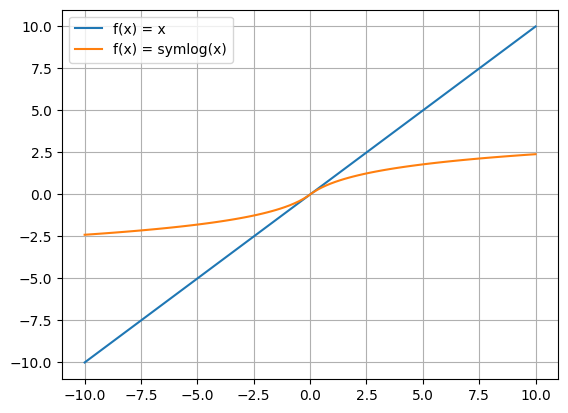

In [14]:
# график f(x) = x и f(x) = symlog(x)
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 100)
plt.plot(x, x, label='f(x) = x')
plt.plot(x, np.sign(x) * np.log(np.abs(x) + 1), label='f(x) = symlog(x)')
plt.legend()
plt.grid()
plt.show()

In [15]:
def symlog(x):
    """
    Compute symlog values for a vector `x`. 
    It's an inverse operation for symexp.
    """
    return np.sign(x) * np.log(np.abs(x) + 1)

def softmax(xs, temp=1.):
    exp_xs = np.exp((xs - xs.max()) / temp)
    return exp_xs / exp_xs.sum()

def sample_prioritized_batch(replay_buffer, n_samples):
    # Sample randomly `n_samples` examples from replay buffer 
    # weighting by priority (example's TD error) and split an array 
    # of sample tuples into arrays:
    #    states, actions, rewards, next_states, terminateds
    # Also, keep samples' indices (into `indices`) to return them too!
    # Note that each sample in replay buffer is a tuple:
    #   (priority, state, action, reward, next_state, terminated)
    # Use 
    """<codehere>"""
    # Извлекаем приоритеты (TD-ошибки) из буфера
    losses = [sample[0] for sample in replay_buffer]

    # Преобразуем ошибки через symlog и softmax в вероятности
    probs = softmax(symlog(losses))

    # Случайный выбор индексов с вероятностями, соответствующими приоритетам
    indices = np.random.default_rng().choice(
        len(replay_buffer), n_samples, p=probs
    )

    # Извлекаем состояния, действия, награды, следующие состояния и признаки завершения для выбранных индексов
    states, actions, rewards, next_states, terminateds = [], [], [], [], []
    for i in indices:
        _, s, a, r, n_s, terminated = replay_buffer[i]
        states.append(s)
        actions.append(a)
        rewards.append(r)
        next_states.append(n_s)
        terminateds.append(terminated)
    """</codehere>"""
        
    batch = (
        np.array(states), np.array(actions), np.array(rewards), 
        np.array(next_states), np.array(terminateds)
    )
    return batch, indices

def update_batch(replay_buffer, indices, batch, new_priority):
    """Updates batches with corresponding indices 
    replacing their priority values."""
    """Обновляет приоритеты для выбранных примеров"""
    states, actions, rewards, next_states, terminateds = batch
    
    for i in range(len(indices)):
        # Создаем новый кортеж с обновленным приоритетом
        new_batch = (
            new_priority[i], states[i], actions[i], rewards[i], 
            next_states[i], terminateds[i]
        )
        # Обновляем пример в буфере
        replay_buffer[indices[i]] = new_batch
        
def sort_replay_buffer(replay_buffer):
    """Sorts replay buffer to move samples with 
    lesser priority to the beginning ==> they will be 
    replaced with the new samples sooner."""
    new_rb = deque(maxlen=replay_buffer.maxlen)
    # Сортировка по первому элементу кортежа (priority)
    # Примеры с меньшим приоритетом оказываются в начале и будут заменены первыми
    new_rb.extend(sorted(replay_buffer, key=lambda sample: sample[0]))
    return new_rb

In [16]:
def run_dqn_prioritized_rb(
        env_name="CartPole-v1", 
        hidden_dims=(256, 256), lr=1e-3, gamma=0.99,
        eps_st=.4, eps_end=.02, eps_dur=.25, total_max_steps=100_000,
        train_schedule=4, replay_buffer_size=400, batch_size=32,
        eval_schedule=1000, smooth_ret_window=5, success_ret=500.
):
    env = gym.make(env_name)
    replay_buffer = deque(maxlen=replay_buffer_size)
    eval_return_history = deque(maxlen=smooth_ret_window)
    
    Q = create_network(
        input_dim=env.observation_space.shape[0], 
        hidden_dims=hidden_dims, 
        output_dim=env.action_space.n
    )
    opt = torch.optim.Adam(Q.parameters(), lr=lr)
    
    s, _ = env.reset()
    done = False

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(
            eps_st, eps_end, eps_dur * total_max_steps, global_step
        )
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, terminated, truncated, _ = env.step(a)
        
        # Compute new sample loss (compute w/o gradients!)
        # Вычисляем TD-ошибку без градиентов (используется как приоритет)
        """<codehere>"""
        with torch.no_grad():
            loss = compute_td_loss(
                Q, [s], [a], [r], [s_next], [terminated],
                gamma=gamma
            )
            loss = loss.numpy()
        """</codehere>"""

        # Добавляем переход в буфер воспроизведения
        replay_buffer.append((loss, s, a, r, s_next, terminated))
        done = terminated or truncated
        
        if global_step % train_schedule == 0:
             # Выбираем батч из буфера на основе приоритетов
            train_batch, indices = sample_prioritized_batch(
                replay_buffer, batch_size
            )
            states, actions, rewards, next_states, terminateds = train_batch
            
            # Обучаем сеть
            opt.zero_grad()
            loss, td_losses = compute_td_loss(
                Q, states, actions, rewards, next_states, terminateds,
                gamma=gamma, out_non_reduced_losses=True
            )
            loss.backward()
            opt.step()
            
            # Обновляем приоритеты в буфере
            update_batch(
                replay_buffer, indices, train_batch, td_losses.numpy()
            )

        # with much slower scheduler periodically re-sort replay buffer
        # such that it will overwrite the least important samples
        if global_step % (10 * train_schedule) == 0:             
            replay_buffer = sort_replay_buffer(replay_buffer)
        
        if global_step % eval_schedule == 0:
            eval_return = eval_dqn(env_name, Q)
            eval_return_history.append(eval_return)
            avg_return = np.mean(eval_return_history)
            print(f'{global_step=} | {avg_return=:.3f} | {epsilon=:.3f}')
            if avg_return >= success_ret:
                print('Решено!')
                # break
                return Q

        s = s_next
        if done:
            s, _ = env.reset()
            done = False

Q_dqn_prioritized_rb_trained = run_dqn_prioritized_rb(eval_schedule=250)

global_step=250 | avg_return=16.000 | epsilon=0.396
global_step=500 | avg_return=16.500 | epsilon=0.392
global_step=750 | avg_return=22.000 | epsilon=0.389
global_step=1000 | avg_return=26.250 | epsilon=0.385
global_step=1250 | avg_return=69.600 | epsilon=0.381
global_step=1500 | avg_return=80.600 | epsilon=0.377
global_step=1750 | avg_return=125.200 | epsilon=0.373
global_step=2000 | avg_return=134.800 | epsilon=0.370
global_step=2250 | avg_return=181.000 | epsilon=0.366
global_step=2500 | avg_return=177.800 | epsilon=0.362
global_step=2750 | avg_return=227.000 | epsilon=0.358
global_step=3000 | avg_return=279.000 | epsilon=0.354
global_step=3250 | avg_return=362.800 | epsilon=0.351
global_step=3500 | avg_return=408.800 | epsilon=0.347
global_step=3750 | avg_return=463.400 | epsilon=0.343
global_step=4000 | avg_return=424.000 | epsilon=0.339
global_step=4250 | avg_return=353.200 | epsilon=0.335
global_step=4500 | avg_return=294.800 | epsilon=0.332
global_step=4750 | avg_return=229.800

In [17]:
# Визуализируем поведение обученной сети
visualize_dqn_policy(Q_dqn_prioritized_rb_trained, video_path="videos/dqn-prioritized-rb-cartpole/")

/opt/miniconda3/envs/ppo/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-prioritized-rb-cartpole folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-prioritized-rb-cartpole/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-prioritized-rb-cartpole/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kurise/Work/AI-Masters/RL/seminar-4-dqn/videos/dqn-prioritized-rb-cartpole/rl-video-episode-0.mp4
Total reward: 500.0
